In [18]:
import classiq
from classiq import *

In [33]:
size = 4
vertices_num = 16
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0 for _ in range(vertices_num)]
    prob[(i+1)% 16]=0.5
    prob[(i-1)% 16]=0.5
    if i ==0:
      prob[15]=0
      prob[1]=1
    elif i==15:
      prob[0]=0
      prob[14]=1
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

This is the circuit I got.

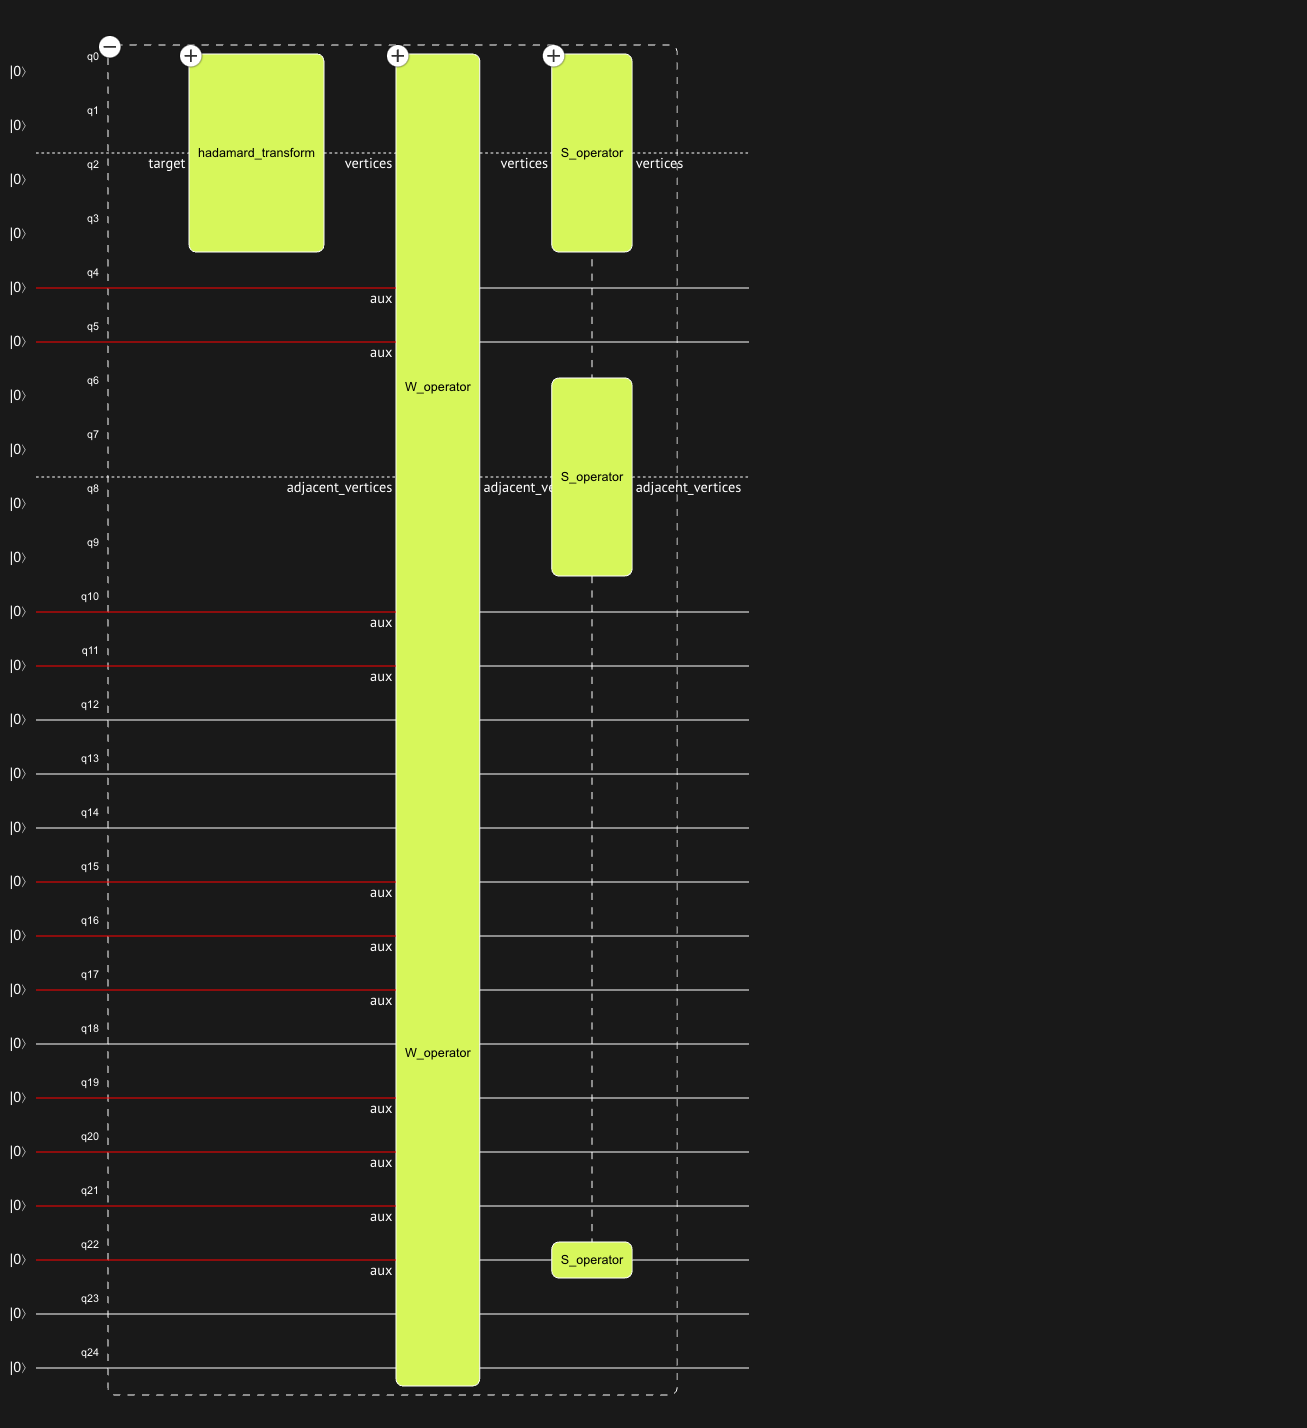

As you can see we have our first subcircuit called Hadamard Transform, where we put our 4 qubits into superposition.

It is then followed by W_operator, and S operator. W operator is the so called Coin Operator or Walk operator, which prepares the probability for the next movement in the graph followed by diffuser. C_Operator prepares all 16 nodes with their probabilities and store them in aux qubits.

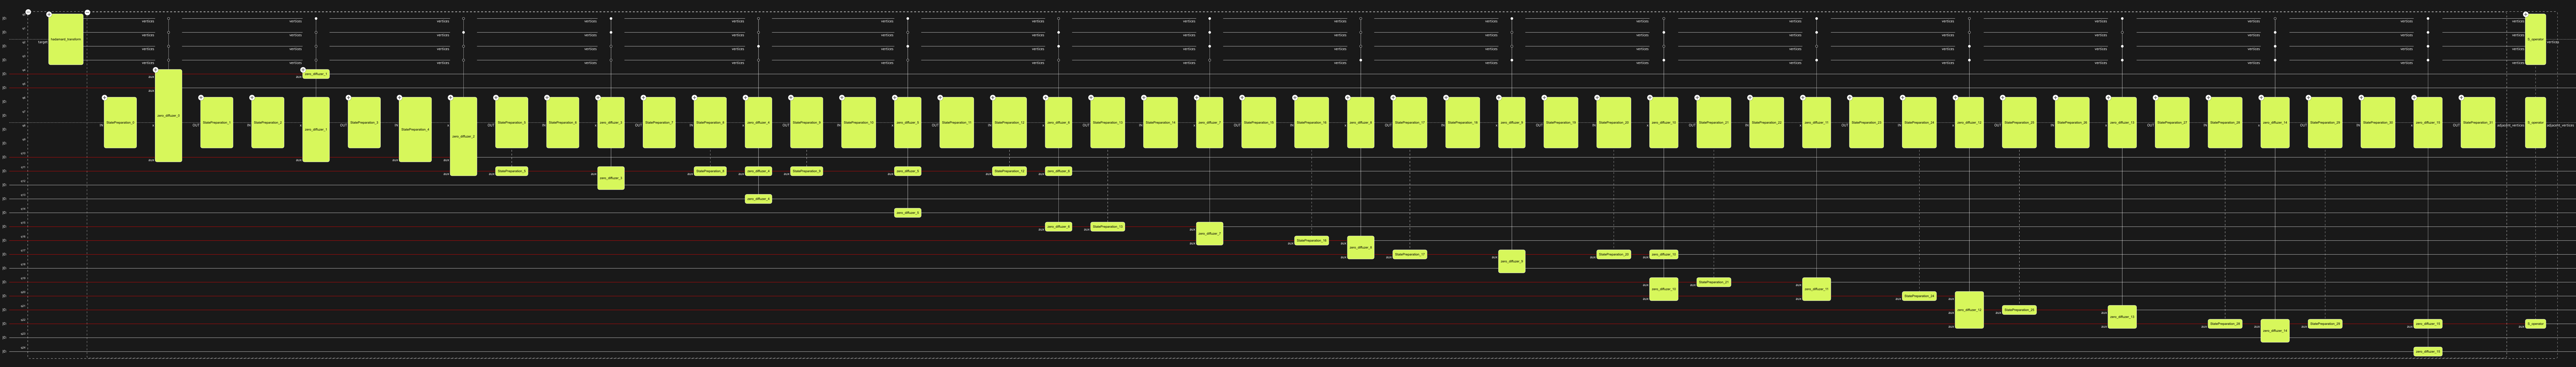

Then we have S_Operator part. It checks by using edge oracle for our specific graph if the vertices are connected by edge, and performs bitwise_swap if they're connected.

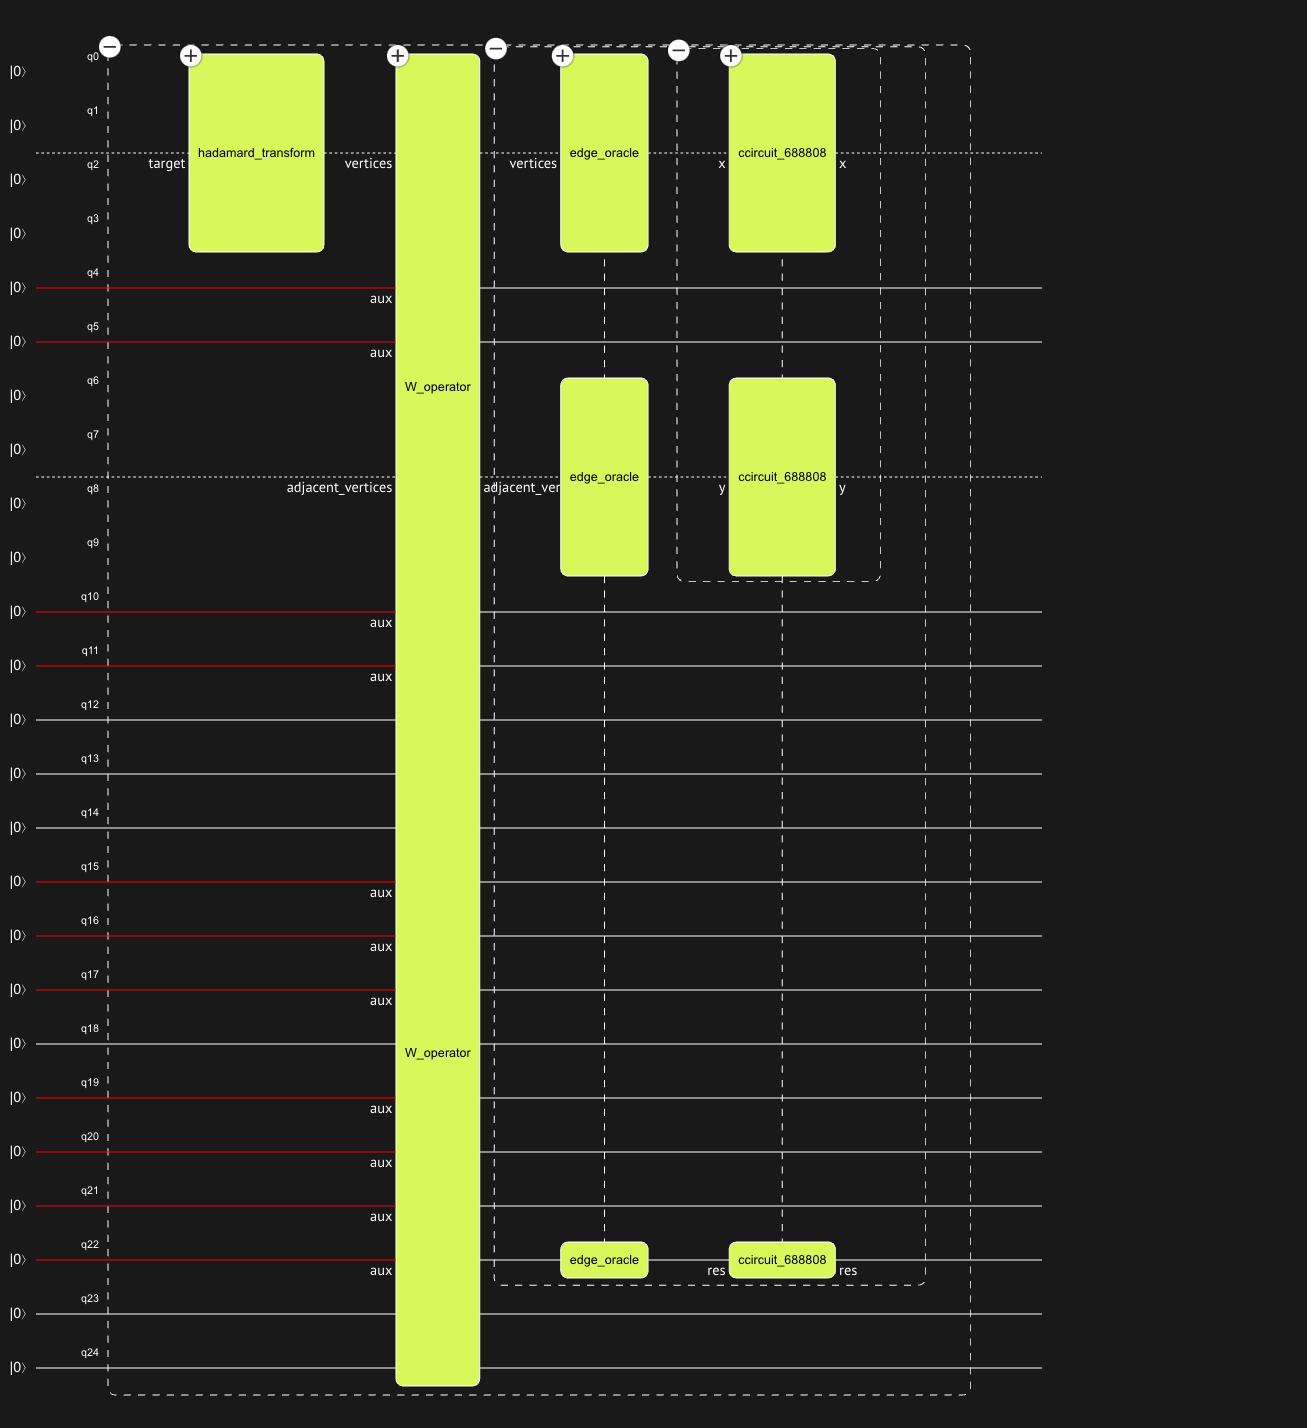

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx

def run_quantum_circuit(num_steps):
    probabilities = np.zeros((num_steps, 16))
    probabilities[0][0] = 1
    for step in range(1, num_steps):
        prev_probs = probabilities[step-1]
        new_probs = np.zeros(16)
        for i in range(16):
            if i > 0:
                new_probs[i-1] += 0.5 * prev_probs[i]
            if i < 15:
                new_probs[i+1] += 0.5 * prev_probs[i]
        probabilities[step] = new_probs
    return probabilities

G = nx.path_graph(16)
pos = {i: (i, 0) for i in range(16)}

num_steps = 100
probabilities = run_quantum_circuit(num_steps)

fig, ax = plt.subplots(figsize=(16, 6))

def update(frame):
    ax.clear()

    node_sizes = [15000 * prob for prob in probabilities[frame]]

    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=node_sizes, ax=ax)

    for i, (x, y) in pos.items():
        ax.text(x, y, str(i), ha='center', va='center', fontweight='bold')

    ax.set_title(f'Quantum Walk Step {frame}')
    ax.set_xlim(-1, 16)
    ax.set_ylim(-0.5, 0.5)

    return ax.collections + ax.texts

anim = FuncAnimation(fig, update, frames=num_steps, interval=1000, blit=False, repeat=True)

anim.save('quantum_walk_linear.gif', writer='pillow', fps=1)

plt.close()

The idea of following animation came from Qiskit. Size of balls illustrate probability of walker being in some step after starting from node 0 for 100 consecutive steps.

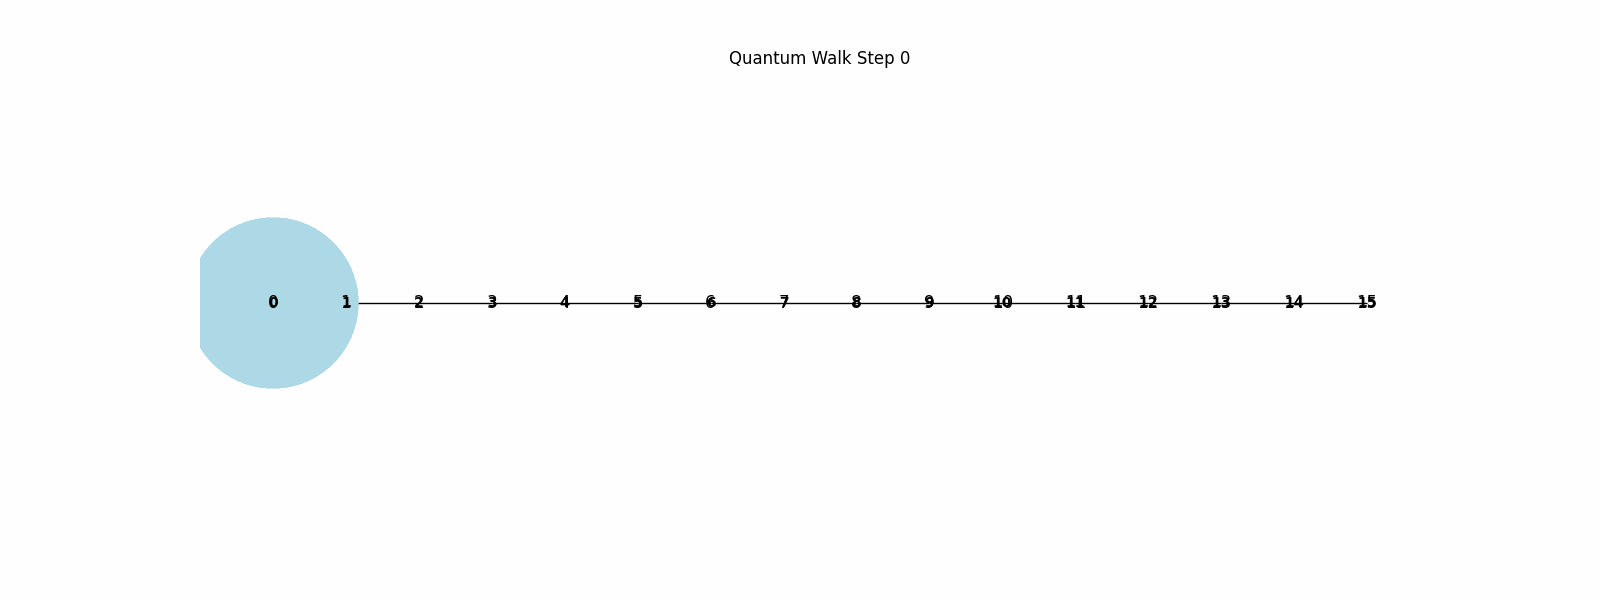